In [ ]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-SmolVLM-2

In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

In [15]:
pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.


In [32]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch
from abc import ABC, abstractmethod


class VideoModel(ABC):
    """Abstract class for video models."""

    @abstractmethod
    def predict_video(self, video_path: str, prompt: str, max_tokens: int) -> str:
        """Predict the action in the video."""
        pass

    @abstractmethod
    def predict_image(self, image1_path: str, image2_path: str, prompt: str, max_tokens: int) -> str:
        """Predict the description of an image"""
        pass

class SmolVLM(VideoModel):
    """A video model implementation for SmolVLM."""

    def __init__(self):
        model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"
        processor = AutoProcessor.from_pretrained(model_path)
        if torch.cuda.is_available():
            model = AutoModelForImageTextToText.from_pretrained(
                model_path,
                torch_dtype=torch.bfloat16,
                _attn_implementation="flash_attention_2",
                device_map="cuda"
            )
        else:
            model = AutoModelForImageTextToText.from_pretrained(
                model_path,
                torch_dtype=torch.bfloat16,
                device_map="cpu"
            )


        self.processor = processor
        self.model = model

    def predict_video(self, video_path: str, prompt: str, max_tokens: int) -> str:
        """Predict the action in the video."""
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "video", "path": video_path},
                    {"type": "text", "text": prompt}
                ]
            },
        ]

        inputs = self.processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt",
        ).to(self.model.device, dtype=torch.bfloat16)

        generated_ids = self.model.generate(**inputs, do_sample=False, max_new_tokens=max_tokens)
        generated_texts = self.processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        return generated_texts[0]

    def predict_image(self, image1_path: str, image2_path: str, prompt: str, max_tokens: int) -> str:
        """Predict the description of an image"""
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "url": image1_path},
                    {"type": "image", "url": image2_path},            
                ]
            },
        ]
            

        inputs = self.processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt",
        ).to(self.model.device, dtype=torch.bfloat16)

        generated_ids = self.model.generate(**inputs, do_sample=False, max_new_tokens=max_tokens)
        generated_texts = self.processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        return generated_texts[0]

In [34]:
my_model = SmolVLM()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
description = my_model.predict_video('https://samplelib.com/lib/preview/mp4/sample-5s.mp4', 'Describe this video in detail', 500)

In [40]:
print(description)

User: You are provided the following series of six frames from a 0:00:05 [H:MM:SS] video.

Frame from 00:00:
Frame from 00:01:
Frame from 00:02:
Frame from 00:03:
Frame from 00:04:
Frame from 00:05:

Describe this video in detail
Assistant: The video presents a serene park scene, bathed in sunlight, with lush green trees and a well-maintained grassy area. A wooden bench is situated in the foreground, inviting viewers to sit and enjoy the tranquil setting. In the background, a white van and a blue bus are parked, suggesting a nearby parking area. The park is devoid of people, adding to the peaceful atmosphere. The video captures the essence of a quiet, sunny day in a park, with the natural beauty of the trees and the calm of the surroundings creating a sense of tranquility.


SO:  
First thing cars in the background are moving.  
Second this model is splitting into 1s shots and I assume takes one frame from each second.

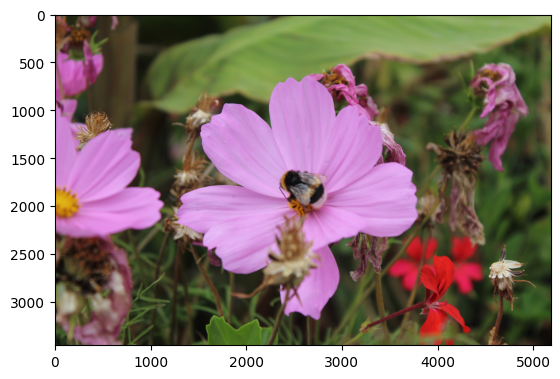

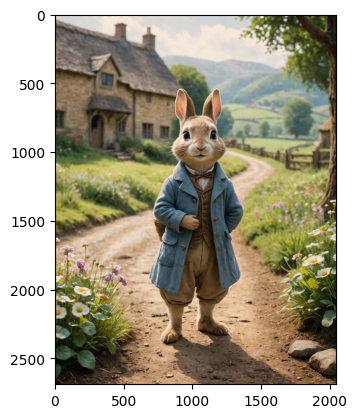

In [54]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

url1 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
response = requests.get(url1)
img = Image.open(BytesIO(response.content))
plt.figure()
plt.imshow(img)
plt.show


url2 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
response = requests.get(url2)
img = Image.open(BytesIO(response.content))
plt.figure()
plt.imshow(img)
plt.show()


In [56]:
images_description = my_model.predict_image(url1, url2, 'Describe these two images', 500)

In [58]:
print(images_description)

User: Describe these two images









Assistant: The image presents a charming scene of a rabbit dressed in a blue coat and brown trousers, standing on a dirt path in a quaint countryside setting. The rabbit, with its large ears and long tail, is the focal point of the image. It is positioned in the center of the frame, facing the camera, giving the impression of a friendly encounter.

The path on which the rabbit stands is surrounded by lush greenery, with trees and bushes lining the sides. The path leads the viewer's eye towards a stone cottage in the background, adding to the rustic charm of the scene. The cottage, with its thatched roof and chimneys, exudes a sense of warmth and homeliness.

The sky above is a clear blue, with a few clouds scattered across it, suggesting a bright and sunny day. The overall color palette of the image is dominated by greens, browns, and blues, creating a harmonious and peaceful atmosphere. The image does not contain any discernible text. The relat